## Lab 10 - Clasificación de Perros y Gatos

Stefano Aragoni, Carol Arévalo, Luis Diego Santos
__________



### Importar Librerías


In [109]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import cv2
import random
import tensorflow as tf
from PIL import Image
from skimage import color, filters, measure

## 1.1 Lectura del Dataset

### Lectura y Procesamiento de Imagenes

In [110]:
def is_image_corrupted(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return False
    except:
        return True

def contrast_stretching(image):
    # Compute the minimum and maximum intensity values of the image.
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Define the new intensity range for the image.
    new_min = 0
    new_max = 255
    
    # Compute the scaling factor.
    scale = (new_max - new_min) / (max_val - min_val)
    
    # Apply the scaling factor to each pixel of the image.
    stretched_image = (image - min_val) * scale + new_min
    
    # Convert the image to 8-bit unsigned integer format.
    stretched_image = np.clip(stretched_image, 0, 255).astype(np.uint8)
    
    return stretched_image


In [111]:
def load_images(path, size=(100, 100)):
    images = []
    labels = []

    dirs = ["Cat", "Dog"]

    for dir in dirs:
        elements = os.listdir(path+'/'+dir)
        random.shuffle(elements)

        contador = 0

        for file in elements:
            if file.endswith('.jpg'):
                img_path = os.path.join(path+'/'+dir, file)
                label = 1 if 'Dog' == dir else 0

                corrupta = is_image_corrupted(img_path)

                if corrupta:
                    continue

                # Leer imagen a color
                img = cv2.imread(img_path)

                try:
                    img = contrast_stretching(img)

                    # Aplicar filtro bilateral con un diámetro de pixel de 9 y un rango de color de 75
                    img = cv2.bilateralFilter(img, 9, 75, 75)
                    
                    # Convertir imagen a escala de grises
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Normalizar valores de píxeles
                    img = img / 255.0

                    img = contrast_stretching(img)

                    # expand the image to 100x100
                    img = cv2.resize(img, size)

                    # Girar imagen aleatoriamente
                    if random.random() < 0.5:
                        opt = random.randint(0, 3)

                        if opt == 1:
                            img = cv2.rotate(img, cv2.ROTATE_180)

                        elif opt == 2:
                            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

                        elif opt == 3:
                            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

                     # Cropear imagen aleatoriamente
                    if random.random() < 0.5:
                        h, w = img.shape
                        crop_size = random.randint(70, 90)
                        top = random.randint(0, h - crop_size)
                        left = random.randint(0, w - crop_size)
                        img = img[top:top+crop_size, left:left+crop_size]
                        img = cv2.resize(img, size)

                    # Flippea imagen aleatoriamente
                    if random.random() < 0.5:
                        img = cv2.flip(img, 1)

                    # Zommea imagen aleatoriamente
                    if random.random() < 0.5:
                        # Aplicar umbral adaptativo para binarizar imagen
                        binary_img = img > filters.threshold_local(img, block_size=40)

                        # Label the objects in the binary image
                        labeled_img = measure.label(binary_img)

                        # Find the properties of the labeled objects
                        properties = measure.regionprops(labeled_img)

                        # Find the object with the largest area
                        max_area = 0
                        max_area_index = 0
                        for i, prop in enumerate(properties):
                            if prop.area > max_area:
                                max_area = prop.area
                                max_area_index = i

                        # Extract the coordinates of the bounding box of the object
                        min_row, min_col, max_row, max_col = properties[max_area_index].bbox

                        # Crop the image to the bounding box of the object
                        img = img[min_row:max_row, min_col:max_col]

                    # expand the image to 100x100
                    img = cv2.resize(img, size)

                    if random.random() < 0.2:
                        images.append(img)
                        labels.append(label)

                    # # show image on popup
                    # cv2.imshow('image', img)
                    # cv2.waitKey(0)
                    # cv2.destroyAllWindows()

                    images.append(img)
                    labels.append(label)
                            
                    if contador == 1500:
                        break

                    contador += 1

                except Exception as e:
                    pass

    return np.array(images), np.array(labels)

### Importar Imagenes y Split de Dataset

Se escogió limitar la cantidad de fotos a analizar debido a que nuestras computadoras no soportaban leer y procesar las 24,000+ imágenes disponibles. En otras palabras, se escogió no procesar y limpiar todas las imágenes (así reduciendo la cantidad de imagenes unicas analizadas) para poder obtener un resultado más rápido y debido a la falta de procesamiento computacional.

En este caso, se optó por tenes aproximadamente 1,500 imágenes de cada clase (gatos y perros), sin embargo, hay un factor aleatorio. Por tal razón, es necesario implementar un método de balanceo de clases.

In [112]:
# Definir ruta del conjunto de datos
data_path = './PetImages'

# Cargar imágenes y etiquetas
images, labels = load_images(data_path)

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


In [113]:
# Comprobar tamaños de los conjuntos
print('\nNúmero de imágenes por clase:', np.bincount(labels))

ros = RandomOverSampler(random_state=42)
images, labels = ros.fit_resample(images.reshape(-1, 100*100), labels)
images = images.reshape(-1, 100, 100)

# Comprobar tamaños de los conjuntos
print('\nNúmero de imágenes por clase:', np.bincount(labels))


Número de imágenes por clase: [1815 1792]

Número de imágenes por clase: [1815 1815]


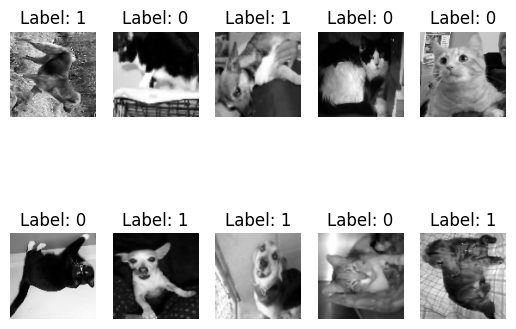

In [114]:
# Elegir 10 imágenes aleatorias para mostrar
random_idx = random.sample(range(0, len(images)), 10)
random_images = images[random_idx, :]
random_labels = labels[random_idx]

# Mostrar imágenes
for i in range(0, len(random_images)):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title('Label: ' + str(random_labels[i]))
    plt.imshow(random_images[i], cmap='gray')

In [126]:
# Dividir conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=55)

# Verificar tamaños de los conjuntos
print('\nTamaño del conjunto de entrenamiento:', X_train.shape)
print('Tamaño del conjunto de prueba:', X_test.shape)


Tamaño del conjunto de entrenamiento: (2904, 100, 100)
Tamaño del conjunto de prueba: (726, 100, 100)


In [127]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

## 1.2 Construccion del Modelo

In [117]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=10,
          verbose=1,
          steps_per_epoch=300)
 

Epoch 1/10
300/300 [==============================] - 44s 139ms/step - loss: 0.8866 - accuracy: 0.5564
Epoch 2/10
300/300 [==============================] - 43s 145ms/step - loss: 0.7602 - accuracy: 0.5985
Epoch 3/10
300/300 [==============================] - 44s 148ms/step - loss: 0.6449 - accuracy: 0.6713
Epoch 4/10
300/300 [==============================] - 43s 145ms/step - loss: 0.5914 - accuracy: 0.6984
Epoch 5/10
300/300 [==============================] - 38s 128ms/step - loss: 0.5264 - accuracy: 0.7498
Epoch 6/10
300/300 [==============================] - 39s 129ms/step - loss: 0.4720 - accuracy: 0.7789
Epoch 7/10
300/300 [==============================] - 42s 140ms/step - loss: 0.4431 - accuracy: 0.7989
Epoch 8/10
300/300 [==============================] - 44s 148ms/step - loss: 0.3855 - accuracy: 0.8290
Epoch 9/10
300/300 [==============================] - 42s 139ms/step - loss: 0.3448 - accuracy: 0.8527
Epoch 10/10
300/300 [==============================] - 29s 95ms/step - lo

## 1.3 Desempeño del Modelo

En este caso, se optó por utilizar Accuracy como métrica de desempeño. Esto debido a que el dataset está balanceado y no hay una clase que sea más importante que la otra. Asimismo, esta métrica es fácil de interpretar y de calcular. Finalmente, esta presenta la ventaja de que no es necesario tener un conocimiento previo del dataset para poder utilizarla. 

En este caso, el Accuracy del dataset de Training es de 90%. Por otro lado, el Accuracy del dataset de Testing es de 89%. 

En este caso, dichos valores pueden variar en cada ronda debido a que a la hora de leer las imágenes, no se leen en orden y se seleccionan de manera aleatoria. Por tal razón, el modelo puede tener un desempeño diferente en cada ejecución.

In [128]:
test_loss, test_acc = model.evaluate(X_train, y_train, verbose=1)
print('\nAccuracy (Training):', test_acc)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('\nAccuracy (Testing):', test_acc)

91/91 [==============================] - 10s 111ms/step - loss: 0.2510 - accuracy: 0.9036

Accuracy (Training): 0.9035812616348267
23/23 [==============================] - 3s 112ms/step - loss: 0.2870 - accuracy: 0.8939

Accuracy (Testing): 0.8939393758773804
